# Study Analysis

Analysis of the study responses, using hypothesis testing to confirm whether the effect of LIME explanations on user understanding is statistically significant. 

**User understanding Metric**: Weighted Kappa score of their estimated model predictions versus actual model predictions.

**Test Statistic**: Difference in means between mean weighted kappa scores for treatment vs control group

**Null Hypothesis**: No difference in means between treatment vs control group (i.e. weighted kappa scores are i.i.d across both groups)

**p-value Significance Threshold**: 0.05

i.e. Probability under the null hypothesis of seeing a more extreme test statistic is less than 0.05 (i.e. really unlikely). Therefore we can conclude null hypothesis is false.

## Set-up

### Import libraries

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import cohen_kappa_score, mean_squared_error, accuracy_score
import joblib

### Set Pandas display options

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option('max_rows', None)
pd.set_option('max_seq_item', None)

### Set up working directory

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/My Drive/MSc Data Science/Research Project/data')

In [5]:
!ls

petfinder-adoption-prediction  study_responses_qual_data.csv
study_responses.csv


### Set Random Seed

In [6]:
# Random seed function 

seed=10

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    
set_seed(seed)

## Read in data

In [7]:
df = pd.read_csv('study_responses.csv').set_index(['group','response_id'])

In [8]:
# replace labels with numbers

labels_map = {
    '0-7 Days': 0,
    '8-30 Days':1,
    '31-90 Days':2,
    '100+ Days':3
}

prediction_cols = [col for col in df.columns if 'prediction' in col and 'score' not in col]
for col in prediction_cols:
    df[col] = df[col].apply(lambda x: labels_map[x])
    df[col] = pd.to_numeric(df[col])

In [9]:
# split out predictions and qualitative data

# predictions
preds = df[prediction_cols].copy()

# qualitative data
new_cols = [
            'What part(s) of the information provided for each example did you find most helpful in understanding how the model makes predictions, and why?',
            'What part(s) of the information provided for each example did you find unhelpful and/or confusing in understanding how the model makes predictions, and why?',
            "What additional information would you like to have seen to improve your understanding of the model's predictions?"
]

qual_data = df[['most_useful','least_useful','anything_else']].copy()
qual_data.columns = new_cols


## Weighted Kappa Scores

In [10]:
# define weighted kappa metric
def qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [11]:
# calculate weighted kappa scores for each response

# define actual model predictions
actuals = [1,0,2,0,3,2,3,1,3,2]

# calculate scores
qwks = preds.apply(lambda x: qwk(actuals,x),axis=1)

## Prediction Accuracy

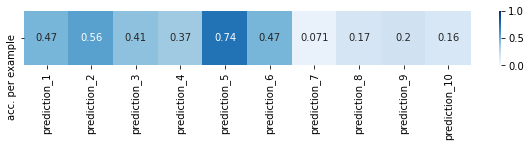

In [12]:
# calculate prediction accuracy per example overall
accs = (np.sum(np.array(preds.apply(lambda x: np.array(actuals) == np.array(x),axis=1))*1)/preds.shape[0]).reshape(1,-1)

accs = pd.DataFrame(data=accs, columns=preds.columns, index=['acc. per example'])

fig, ax = plt.subplots(figsize=(10,1))
sns.heatmap(accs,vmin=0,vmax=1,cmap='Blues',annot=True, ax=ax)

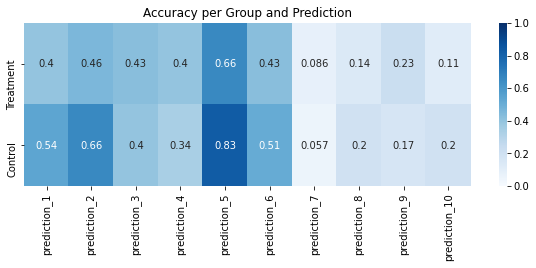

In [13]:
# calculate prediction accuracy per example (for treatment)
accs_t = (np.sum(np.array(preds[preds.index.get_level_values(0)=='Treatment'].apply(lambda x: np.array(actuals) == np.array(x),axis=1))*1)/\
        preds[preds.index.get_level_values(0)=='Treatment'].shape[0]).reshape(1,-1)

accs_t = pd.DataFrame(data=accs_t, columns=preds.columns, index=['Treatment'])

# calculate prediction accuracy per example (for control)
accs_c = (np.sum(np.array(preds[preds.index.get_level_values(0)=='Control'].apply(lambda x: np.array(actuals) == np.array(x),axis=1))*1)/\
        preds[preds.index.get_level_values(0)=='Control'].shape[0]).reshape(1,-1)

accs_c = pd.DataFrame(data=accs_c, columns=preds.columns, index=['Control'])

accs = pd.concat([accs_t,accs_c],axis=0)

fig, ax = plt.subplots(figsize=(10,3))
ax.set_title('Accuracy per Group and Prediction')
sns.heatmap(accs,vmin=0,vmax=1,cmap='Blues',annot=True, ax=ax)


## Calculate Test statistic

In [14]:
# define function to calculate diff of means test statistic
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1)-np.mean(data_2)

    return diff

In [19]:
# isolate treatment and control groups scores
qwks_t = qwks[qwks.index.get_level_values(0)=='Treatment']
qwks_c = qwks[qwks.index.get_level_values(0)=='Control']

# calculate test statistic
t_actual = diff_of_means(qwks_t,qwks_c)
# t_actual = diff_of_means(qwks_c,qwks_t)

print('qwk_t:',np.mean(qwks_t))
print('qwk_t_sd:',np.std(qwks_t))
print('qwk_c:',np.mean(qwks_c))
print('t_actual:',t_actual)


qwk_t: 0.30172679562773475
qwk_t_sd: 0.29475186639805234
qwk_c: 0.41724624942468247
t_actual: -0.11551945379694772


## Calculate p-value

In [ ]:
# function to generate permuted (i.e shuffled) data sample which models the null hypothesis (i.e. treatment and control are i.i.d)
def permutation_sample(data):
    """Generate a permutation sample from two data sets."""

    # shuffle the data
    permuted_data = np.random.permutation(data)

    # Split the shuffled data down the middle into new control and treatment groups
    perm_sample_1 = permuted_data[:data.shape[0]//2]
    perm_sample_2 = permuted_data[data.shape[0]//2:]

    return perm_sample_1, perm_sample_2

In [ ]:
# function to draw test statistic distribution under the null hypothesis (i.e. permutation replicates of test statistic)
def draw_perm_reps(data, func, size=1):
    """Generate multiple permutation replicates."""

    # create empty array to hold test statistic permutation replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutated data sample
        perm_sample_1, perm_sample_2 = permutation_sample(data)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)

    return perm_replicates

In [ ]:
# Generate test statistic distribution under null hypothesis
ts_pr = draw_perm_reps(qwks,diff_of_means, size=10000)

# Calculate p-value (probability of seeing more extreme test statistic under the null hypothesis, than the one observed)
p = np.sum(ts_pr >= t_actual) / len(ts_pr)

# Print the result
print('p-value =', p)

p-value = 0.0307


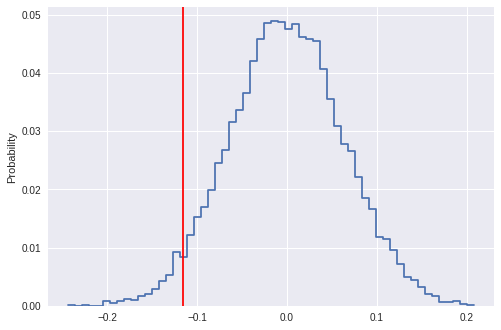

In [ ]:
# Plot t statistic distribution and p-value
plt.style.use('seaborn')
fig, ax = plt.subplots()

sns.histplot(data=ts_pr,stat='probability',element="step",fill=False,ax=ax)
plt.axvline(x=t_actual,color='red') 

plt.show()

**Conclusion**: Under the null hypothesis, there's a very high probability of seeing a more extreme test statistic. Therefore we cannot reject the null hypothesis. It seems LIME explanations make no significant difference on user understanding of model's predictions. 

## Save outputs

In [ ]:
# output qualitative data
os.chdir('/content/drive/My Drive/MSc Data Science/Research Project/data')
qual_data.to_csv('study_responses_qual_data.csv')